# El problema

Una empresa de comercio electrónico desea realizar acciones comerciales sobre ciertos usuarios de su web. Mediante el úso de Google Analytics queremos pronosticar qué usuarios van a ser recurrentes y con ello realizar acciones comerciales sobre aquellos usuarios con más probabilidad de compra.
Antes de aplicar algoritmos de aprendizaje supervisado, nos disponemos a realizar algunas transformaciones en los datos proporcionados.


# Carga de Datos

Carga de las librerías que usaremos más adelante

In [23]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from numpy import corrcoef, transpose, arange
from pylab import pcolor, show, colorbar, xticks, yticks


Cargamos dos tablas por separado. Por un lado los eventos que ha realizado cada usuario y por otro la tabla que nos indica qué usuarios son recurrentes.

In [3]:
eventos = pd.read_csv('eventos.csv', sep = ';')
eventos.head()

,Id,Date,Year,Month_of_year,Event_Category,Event_Action,Total_Events
0,0223ad2e-9782-4beb-87d0-4f7e9461b292,2020-09-16,2020,9,IREQUEST,Approvals task done,1
1,0223ad2e-9782-4beb-87d0-4f7e9461b292,2020-09-16,2020,9,IREQUEST,Content task done,2
2,0223ad2e-9782-4beb-87d0-4f7e9461b292,2020-09-16,2020,9,IREQUEST,Header task done,2
3,0223ad2e-9782-4beb-87d0-4f7e9461b292,2020-09-16,2020,9,IREQUEST,Order task done,1
4,0223ad2e-9782-4beb-87d0-4f7e9461b292,2020-09-16,2020,9,IREQUEST,Publish Draft,1


In [4]:
eventos.shape

(5880, 7)

In [5]:
eventos.dtypes

Id                object
Date              object
Year               int64
Month_of_year      int64
Event_Category    object
Event_Action      object
Total_Events       int64
dtype: object

In [6]:
eventos.head()

,Id,Date,Year,Month_of_year,Event_Category,Event_Action,Total_Events
0,0223ad2e-9782-4beb-87d0-4f7e9461b292,2020-09-16,2020,9,IREQUEST,Approvals task done,1
1,0223ad2e-9782-4beb-87d0-4f7e9461b292,2020-09-16,2020,9,IREQUEST,Content task done,2
2,0223ad2e-9782-4beb-87d0-4f7e9461b292,2020-09-16,2020,9,IREQUEST,Header task done,2
3,0223ad2e-9782-4beb-87d0-4f7e9461b292,2020-09-16,2020,9,IREQUEST,Order task done,1
4,0223ad2e-9782-4beb-87d0-4f7e9461b292,2020-09-16,2020,9,IREQUEST,Publish Draft,1


In [7]:
recurrentes = pd.read_csv('recurrentes.csv', sep = ';')
recurrentes.head()

,Id,Completions
0,01166f4f-c0e0-43bc-a42b-e92db8f39cbf,0.0
1,01185db1-38b8-4a65-8b1d-221d3ce8751f,0.0
2,01312e65-ac91-4f9a-a278-5f1fadc7a1c7,0.0
3,01f55eb5-ec41-4575-b71f-9adceedf53eb,1.0
4,02101d56-eb16-4f67-9ddd-81c3f7d6abb6,0.0


In [8]:
recurrentes.dtypes

Id              object
Completions    float64
dtype: object

## Preparación de datos

Unimos las dos tablas. Para ello creo dos data frames de pandas y los realizo un join con el campo Id

In [9]:
df1 = pd.DataFrame(eventos)
df2 = pd.DataFrame(recurrentes)

Convertimos el campo Completios en categoría

In [10]:
df2['Completions'] = df2['Completions'].astype('object') 
df2.head()

,Id,Completions
0,01166f4f-c0e0-43bc-a42b-e92db8f39cbf,0
1,01185db1-38b8-4a65-8b1d-221d3ce8751f,0
2,01312e65-ac91-4f9a-a278-5f1fadc7a1c7,0
3,01f55eb5-ec41-4575-b71f-9adceedf53eb,1
4,02101d56-eb16-4f67-9ddd-81c3f7d6abb6,0


In [24]:
df_unido = pd.merge(df1, df2, on = 'Id')

In [25]:
df_unido.head()

,Id,Date,Year,Month_of_year,Event_Category,Event_Action,Total_Events,Completions
0,0223ad2e-9782-4beb-87d0-4f7e9461b292,2020-09-16,2020,9,IREQUEST,Approvals task done,1,0
1,0223ad2e-9782-4beb-87d0-4f7e9461b292,2020-09-16,2020,9,IREQUEST,Content task done,2,0
2,0223ad2e-9782-4beb-87d0-4f7e9461b292,2020-09-16,2020,9,IREQUEST,Header task done,2,0
3,0223ad2e-9782-4beb-87d0-4f7e9461b292,2020-09-16,2020,9,IREQUEST,Order task done,1,0
4,0223ad2e-9782-4beb-87d0-4f7e9461b292,2020-09-16,2020,9,IREQUEST,Publish Draft,1,0


Obtengo una tabla con una fila por id de usuario y una columna por cada tipo de "Event_Action", sumando las veces que aparece cada evento correspondiente en cada id de usuario.

In [26]:
df_pivotado = df_unido.pivot_table(values=['Total_Events'], index=['Id'], columns=['Event_Action'], aggfunc=sum)
df_pivotado.shape

(254, 58)

In [27]:
df_pivotado = df_pivotado.fillna(0)

In [28]:
df_pivotado.describe()

Total_Events                                     \
Event_Action Approvals task done Complete Profile Content task done   
count                 254.000000       254.000000        254.000000   
mean                    4.374016         0.137795          4.751969   
std                    14.289147         0.378144         14.492382   
min                     0.000000         0.000000          0.000000   
25%                     0.000000         0.000000          0.000000   
50%                     0.000000         0.000000          0.000000   
75%                     2.000000         0.000000          2.000000   
max                   128.000000         3.000000        128.000000   

                                                                 \
Event_Action Create Draft from Gallery Create Flow Create Group   
count                       254.000000  254.000000   254.000000   
mean                          2.625984    0.015748     0.007874   
std                           7.564079    0.153188     0.125491   
min                           0.000000    0.000000     0.000000   
25%                           0.000000    0.000000     0.000000   
50%                           1.000000    0.000000     0.000000   
75%                           1.000000    0.000000     0.000000   
max                          82.000000    2.000000     2.000000   

                                                                     \
Event_Action Create Iform from Gallery Create Irequest Create Order   
count                       254.000000      254.000000   254.000000   
mean                          0.444882        0.098425     4.314961   
std                           1.086621        1.143013    22.104030   
min                           0.000000        0.000000     0.000000   
25%                           0.000000        0.000000     0.000000   
50%                           0.000000        0.000000     0.000000   
75%                           0.000000        0.000000     0.000000   
max                           7.000000       18.000000   279.000000   

                              ...  \
Event_Action Create Reminder  ...   
count             254.000000  ...   
mean                0.011811  ...   
std                 0.140081  ...   
min                 0.000000  ...   
25%                 0.000000  ...   
50%                 0.000000  ...   
75%                 0.000000  ...   
max                 2.000000  ...   

                                                           \
Event_Action [iceCreamDad.mails.home.scheduled] (not set)   
count                                          254.000000   
mean                                             0.003937   
std                                              0.062746   
min                                              0.000000   
25%                                              0.000000   
50%                                              0.000000   
75%                                              0.000000   
max                                              1.000000   

                                                                 \
Event_Action [iceCreamDad.mails.home.wizard.designer] (not set)   
count                                                254.000000   
mean                                                   0.240157   
std                                                    2.141580   
min                                                    0.000000   
25%                                                    0.000000   
50%                                                    0.000000   
75%                                                    0.000000   
max                                                   31.000000   

                                                        \
Event_Action [iceCreamDad.mails.home.wizard] (not set)   
count                                       254.000000   
mean                                          0.055118   
std                                       

In [29]:
df_pivotado.head()

Total_Events                   \
Event_Action                         Approvals task done Complete Profile   
Id                                                                          
0223ad2e-9782-4beb-87d0-4f7e9461b292                 5.0              0.0   
024df242-00e0-43a9-828b-aa7e94f0735c                 0.0              0.0   
03591a89-98c0-4594-93e8-14097e800ea0                 7.0              1.0   
03c743f6-f545-4e65-ae24-ab5b6a5a7f62                 0.0              0.0   
0446cffc-f040-4aff-9e54-0f23878c9b70                 0.0              0.0   

                                                        \
Event_Action                         Content task done   
Id                                                       
0223ad2e-9782-4beb-87d0-4f7e9461b292               9.0   
024df242-00e0-43a9-828b-aa7e94f0735c               0.0   
03591a89-98c0-4594-93e8-14097e800ea0               8.0   
03c743f6-f545-4e65-ae24-ab5b6a5a7f62               1.0   
0446cffc-f040-4aff-9e54-0f23878c9b70               0.0   

                                                                            \
Event_Action                         Create Draft from Gallery Create Flow   
Id                                                                           
0223ad2e-9782-4beb-87d0-4f7e9461b292                      10.0         0.0   
024df242-00e0-43a9-828b-aa7e94f0735c                       0.0         0.0   
03591a89-98c0-4594-93e8-14097e800ea0                       6.0         0.0   
03c743f6-f545-4e65-ae24-ab5b6a5a7f62                       1.0         0.0   
0446cffc-f040-4aff-9e54-0f23878c9b70                       0.0         0.0   

                                                                             \
Event_Action                         Create Group Create Iform from Gallery   
Id                                                                            
0223ad2e-9782-4beb-87d0-4f7e9461b292          0.0                       0.0   
024df242-00e0-43a9-828b-aa7e94f0735c          0.0                       0.0   
03591a89-98c0-4594-93e8-14097e800ea0          0.0                       1.0   
03c743f6-f545-4e65-ae24-ab5b6a5a7f62          0.0                       0.0   
0446cffc-f040-4aff-9e54-0f23878c9b70          0.0                       0.0   

                                                                   \
Event_Action                         Create Irequest Create Order   
Id                                                                  
0223ad2e-9782-4beb-87d0-4f7e9461b292             0.0          0.0   
024df242-00e0-43a9-828b-aa7e94f0735c             0.0          0.0   
03591a89-98c0-4594-93e8-14097e800ea0             0.0          1.0   
03c743f6-f545-4e65-ae24-ab5b6a5a7f62             0.0          0.0   
0446cffc-f040-4aff-9e54-0f23878c9b70             0.0          0.0   

                                                      ...  \
Event_Action                         Create Reminder  ...   
Id                                                    ...   
0223ad2e-9782-4beb-87d0-4f7e9461b292             0.0  ...   
024df242-00e0-43a9-828b-aa7e94f0735c             0.0  ...   
03591a89-98c0-4594-93e8-14097e800ea0             0.0  ...   
03c743f6-f545-4e65-ae24-ab5b6a5a7f62             0.0  ...   
0446cffc-f040-4aff-9e54-0f23878c9b70             0.0  ...   

                                                                                   \
Event_Action                         [iceCreamDad.mails.home.scheduled] (not set)   
Id                                                                                  
0223ad2e-9782-4beb-87d0-4f7e9461b292                                          0.0   
024df242-00e0-43a9-828b-aa7e94f0735c                                          0.0   
03591a89-98c0-4594-93e8-14097e800ea0                                          0.0   
03c743f6-f545-4e65-ae24-ab5b6a5a7f62                                          0.0   
0446cffc-f040-4aff-9e54-0f23878c9b70                               

In [30]:
df_final = pd.merge(df_pivotado, df2, on = 'Id')

C:\Users\drayanu\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [31]:
df_final.dtypes

Id                                                                                                       object
(Total_Events, Approvals task done)                                                                     float64
(Total_Events, Complete Profile)                                                                        float64
(Total_Events, Content task done)                                                                       float64
(Total_Events, Create Draft from Gallery)                                                               float64
(Total_Events, Create Flow)                                                                             float64
(Total_Events, Create Group)                                                                            float64
(Total_Events, Create Iform from Gallery)                                                               float64
(Total_Events, Create Irequest)                                                                         

Código para cargarla tabla transformada si falla lo anterior, borrar en la versión final

In [32]:
df_final.to_csv('GA.csv')

# Reducción de la dimensionalidad con análisis de correlación entre variables

In [33]:
df_feat = transpose(df_pivotado)
df_feat

Id                                                               0223ad2e-9782-4beb-87d0-4f7e9461b292  \
             Event_Action                                                                               
Total_Events Approvals task done                                                                  5.0   
             Complete Profile                                                                     0.0   
             Content task done                                                                    9.0   
             Create Draft from Gallery                                                           10.0   
             Create Flow                                                                          0.0   
             Create Group                                                                         0.0   
             Create Iform from Gallery                                                            0.0   
             Create Irequest                                                                      0.0   
             Create Order                                                                         0.0   
             Create Reminder                                                                      0.0   
             Delete Flow                                                                          0.0   
             Duplicate Flow                                                                       0.0   
             Extend Trial                                                                         0.0   
             Header task done                                                                     9.0   
             Login                                                                                8.0   
             Logout                                                                               3.0   
             Order task done                                                                      4.0   
             Post Signal                                                                          0.0   
             Publish Draft                                                                        4.0   
             Publish Flow                                                                         0.0   
             Save Profile                                                                         0.0   
             Send Email                                                                           0.0   
             Update Flow                                                                          0.0   
             [CONTACT] Add Tags                                                                   0.0   
             [CONTACT] Remove tag                                                                 0.0   
             [CONTACT] Send email                                                                 0.0   
             [CONTACT] Update Flow                                                                0.0   
             [IREQUEST] Approvals task done                                                       0.0   
             [IREQUEST] Content task done                                                         0.0   
             [IREQUEST] Header task done                                                          0.0   
             [IREQUEST] Order task done                                                           1.0   
             [IREQUEST] Publish Draft                                                             0.0   
             [MAILS] Create draft from Gallery                                                    0.0   
             [SYNC] Create order                                                                  0.0   
             [iceCreamDad.dashboard] (not set)                                                    0.0   
             [iceCreamDad.dashboard] SyntaxError: Unexpected...                                   0.0   
          

Con el fin de que obtener un mejor rendimiento en los algoritmos será necesario identificar aquellas variables que son redundantes, es decir, se puede asumir que representan lo mismo, en este caso se puede utilizar el análisis de correlaciones. Podemos excluir aquellas fuertemente correlacionadas y para ello acudimos a una representación gráfica de la correlación entre variables.

In [21]:
names =  df_feat.index

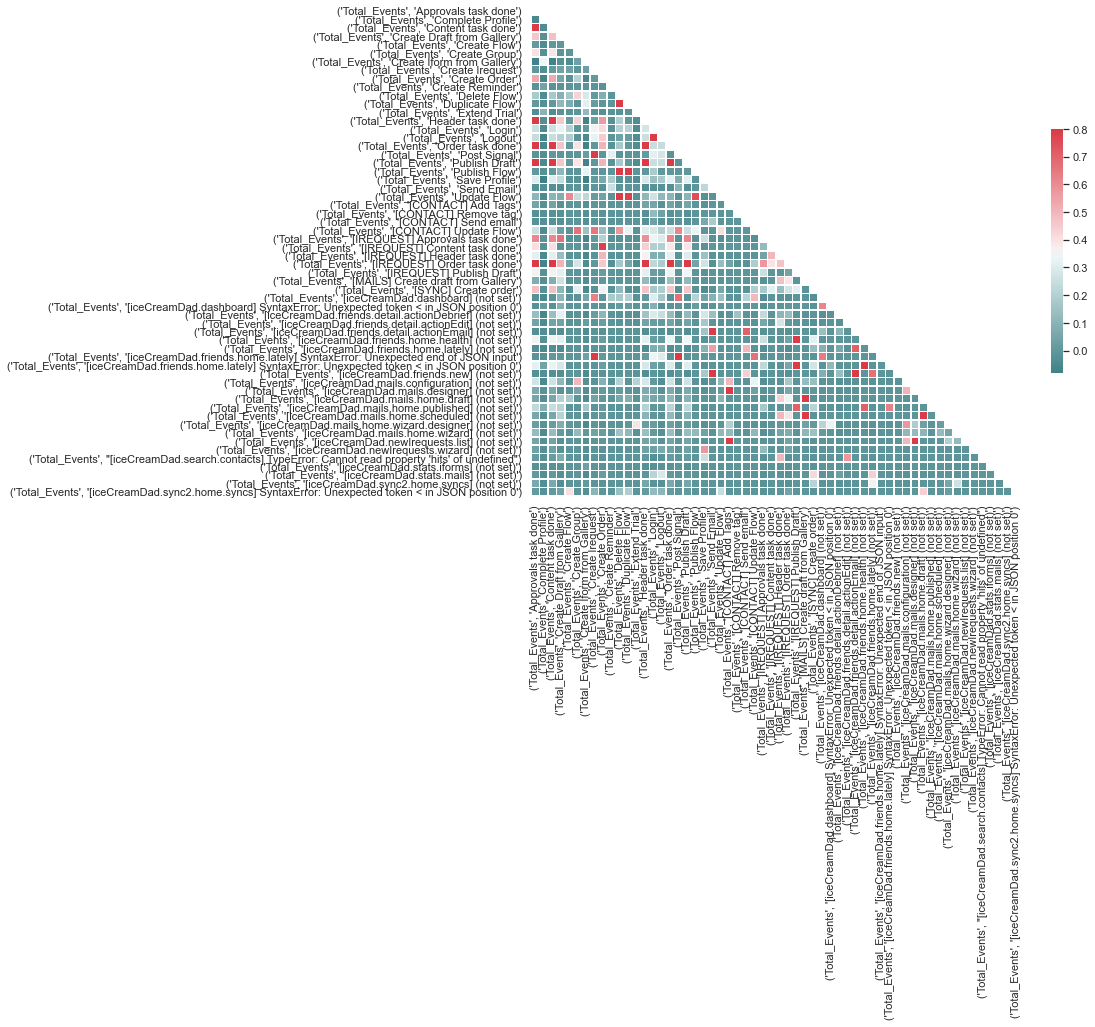

In [22]:
#https://docs.scipy.org/doc/numpy/reference/generated/numpy.corrcoef.html
R = corrcoef(df_feat)

# http://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html
# Generate a mask for the upper triangle
sns.set(style="white")
mask = np.zeros_like(R, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(200, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(R, mask=mask, cmap=cmap, vmax=.8,
            square=True, xticklabels=names, yticklabels=names,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)